# Deteksi Penyakit Otak Menggunakan CNN dan Image Preprocessing

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import accuracy_score
from tkinter import Tk, filedialog

In [13]:
# **1. Load Dataset**
def load_data(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory, image_size=(400, 600), color_mode='grayscale')
    x, y = [], []
    for images, labels in dataset:
        x.extend(images.numpy())
        y.extend(labels.numpy())
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)

In [14]:
train_dir = 'healthy/data_train'
test_dir = 'healthy/data_test'
x_train, y_train = load_data(train_dir)
x_test, y_test = load_data(test_dir)

Found 256 files belonging to 3 classes.


Found 3 files belonging to 3 classes.


In [ ]:
# **2. Data Augmentation**
trainDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2
)
trainGenerator = trainDataGen.flow_from_directory(
    train_dir,
    target_size=(400, 600),
    color_mode='grayscale'
)

class_names = trainGenerator.class_names
print("Class names in dataset:", class_names)  # Cek apakah class order sesuai

Found 256 images belonging to 3 classes.


In [16]:
# **3. Define CNN Model**
tensor_list = np.array(y_train)
output_dim = len(set(tensor_list.tolist()))
input_shape = x_train.shape[1:]

model = Sequential([
    Input(shape=input_shape),
    Conv2D(12, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(24, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(output_dim, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# **4. Train Model**
history = model.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
8/8 [==============================] - 12s 1s/step - loss: 380.4836 - accuracy: 0.5820
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 66.9372 - accuracy: 0.8438
Epoch 3/20
8/8 [==============================] - 12s 2s/step - loss: 6.1357 - accuracy: 0.9766
Epoch 4/20
8/8 [==============================] - 12s 1s/step - loss: 2.8948 - accuracy: 0.9727
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.2357 - accuracy: 0.9961
Epoch 6/20
8/8 [==============================] - 15s 2s/step - loss: 0.4760 - accuracy: 0.9727
Epoch 7/20
8/8 [==============================] - 14s 2s/step - loss: 0.2724 - accuracy: 0.9922
Epoch 8/20
8/8 [==============================] - 14s 2s/step - loss: 0.1674 - accuracy: 0.9883
Epoch 9/20
8/8 [==============================] - 13s 2s/step - loss: 0.1935 - accuracy: 0.9922
Epoch 10/20
8/8 [==============================] - 13s 2s/step - loss: 0.2117 - accuracy: 0.9883
Epoch 11/20
8/8 [===================

In [18]:
# **5. Evaluate Model**
pred_train = model.predict(x_train, verbose=0).argmax(axis=1)
pred_test = model.predict(x_test, verbose=0).argmax(axis=1)
print("Training Accuracy:", accuracy_score(y_train, pred_train))
print("Testing Accuracy:", accuracy_score(y_test, pred_test))

Training Accuracy: 0.9921875
Testing Accuracy: 1.0


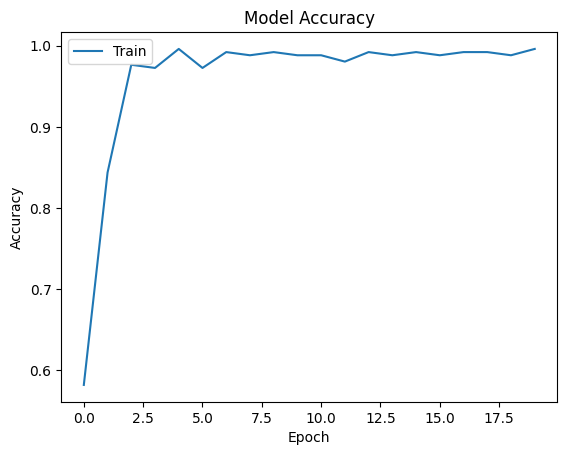

In [19]:
# **6. Plot Training History**
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

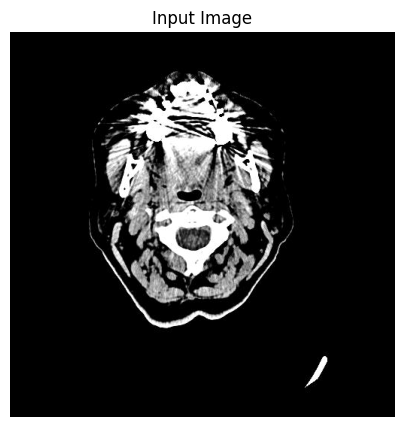

Detected Class: CTBrain_tumor


In [22]:
# **7. Testing on New Data**
def select_image():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
    return file_path

image_path = select_image()
if image_path:
    # Baca dan tampilkan gambar asli
    sample_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(5, 5))
    plt.imshow(sample_image, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Pastikan ukuran sesuai dengan model
    sample_image = cv2.resize(sample_image, (400, 600))  
    sample_image = np.expand_dims(sample_image, axis=-1)  # Tambah dimensi channel
    sample_image = np.expand_dims(sample_image, axis=0)   # Tambah batch dimensi
    
    # Normalisasi gambar sesuai dataset training
    sample_image = sample_image / 255.0  

    # Prediksi kelas gambar
    prediction = model.predict(sample_image, verbose=0).argmax()
    labels = ['CTBrain_aneurysm', 'CTBrain_cancer', 'CTBrain_tumor']
    
    print(f"Detected Class: {labels[prediction]}")
else:
    print("No image selected.")
